In [1]:
import os
import rasterio
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

import tensorflow as tf

from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras import Model
from tensorflow.python.keras.models import Input
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

from keras.utils import normalize
import random

In [2]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.5 MB/s eta 0:00:00


In [3]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [4]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [5]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [6]:

# # Resolve TPU address
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  

# # Connect to the TPU handle and initialize it
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# # Define the strategy
# strategy = tf.distribute.experimental.TPUStrategy(tpu)


<font size=5>Show images</font>

In [7]:
# raster_path = "/kaggle/input/images-soil-erosion/images/image_0_0.jp2"
# with rasterio.open(raster_path, "r", driver="JP2OpenJPEG") as src:
#     raster_img = src.read()
#     raster_meta = src.meta

In [8]:
# plt.figure(figsize=(15,15))
# plt.imshow(raster_img[0],  cmap='gray')

In [9]:
# raster_path = "/kaggle/input/patches-images-split/mask_0_0.jp2"
# with rasterio.open(raster_path, "r", driver="JP2OpenJPEG") as src:
#     raster_img = src.read()
#     raster_meta = src.meta

In [10]:
# plt.figure(figsize=(15,15))
# plt.imshow(raster_img[0],  cmap='gray')

<font size=5>Capture images and masks info as a list</font>

In [11]:
image_directory = '/kaggle/input/images-soil-erosion/images/'
mask_directory = '/kaggle/input/masks-soil-erosion/masks/'

In [12]:
SIZE = 256
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

In [13]:
images = os.listdir(image_directory)
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'jp2'):
#         print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, cv2.IMREAD_COLOR)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))


In [14]:
masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
#     print(i)
    if (image_name.split('.')[1] == 'jp2'):
        image = cv2.imread(mask_directory+image_name, 0)
#         print(mask_directory+image_name)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))


In [15]:
# print(len(image_dataset[0][1]), '\n', len(mask_dataset))

In [16]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
# mask_dataset = np.expand_dims(mask_dataset, axis=3)

In [17]:
#Normalize images
image_dataset = normalize(image_dataset, axis=1)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((mask_dataset),3) /255.

In [18]:
print(image_dataset.shape, '\n', mask_dataset.shape)

(1849, 256, 256, 3) 
 (1849, 256, 256, 1)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 123)

In [20]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [21]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

<font size='5'>For TPU</font>

In [22]:
# # instantiating the model in the strategy scope creates the model on the TPU
# with strategy.scope():
#     model = sm.Unet(BACKBONE, encoder_weights='imagenet') # classes=2, activation='softmax'
# #     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])    
#     model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
# #     class_weights = [0.1, 0.9] # higher weight for underrepresented class
# #     loss = DiceLoss(class_weights=class_weights)
# #     metrics = [IoU(threshold=0.5)]
# #     model.compile(optimizer='adam', loss=loss, metrics=[sm.metrics.iou_score])
# #     model.summary()

# #     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])

<font size='5'>For GPU</font>

In [23]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])
# model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score],)
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

85521592/85521592 [==============================] - 3s 0us/step


In [24]:
history = model.fit(X_train, y_train, 
                    # 32 batch)size is wery large for kaggle gpu
                    batch_size = 2, 
                    # tried different number of epochs (10-100), 10 for reduce expectation
                    epochs=5, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)


Epoch 1/5
832/832 [==============================] - 89s 61ms/step - loss: 1.0395 - iou_score: 8.4380e-04 - val_loss: 1.0158 - val_iou_score: 4.3885e-04
Epoch 2/5
832/832 [==============================] - 49s 59ms/step - loss: 1.0158 - iou_score: 4.3339e-04 - val_loss: 1.0158 - val_iou_score: 3.6922e-04
Epoch 3/5
832/832 [==============================] - 48s 58ms/step - loss: 1.0158 - iou_score: 4.1899e-04 - val_loss: 1.0162 - val_iou_score: 3.9794e-04
Epoch 4/5
832/832 [==============================] - 50s 60ms/step - loss: 1.0159 - iou_score: 4.2616e-04 - val_loss: 1.0155 - val_iou_score: 3.9336e-04
Epoch 5/5
832/832 [==============================] - 48s 58ms/step - loss: 1.0159 - iou_score: 4.1203e-04 - val_loss: 1.0157 - val_iou_score: 3.0403e-04


In [25]:
model.save('/kaggle/working/unet-sm_5.h5')

<font size='5'>Evaluate the model</font>

In [26]:
# _, acc = model.evaluate(X_test, y_test)
# print("Accuracy = ", (acc * 100.0), "%")

In [27]:
# #plot the training and validation accuracy and loss at each epoch
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

1/1 [==============================] - 1s 930ms/step


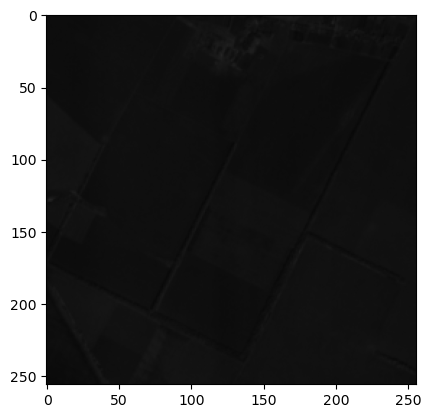

In [28]:
test_img_number = 170#random.randint(0, len(X_test))
# print(test_img_number)
test_img = image_dataset[test_img_number]
plt.imshow(test_img, cmap='gray')

test_img = test_img.astype('uint8')
test_img = cv2.resize(test_img, (256, 256))
# plt.imshow(test_img, cmap='gray')
# test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
# plt.imshow(test_img, cmap='gray')
test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)[0]


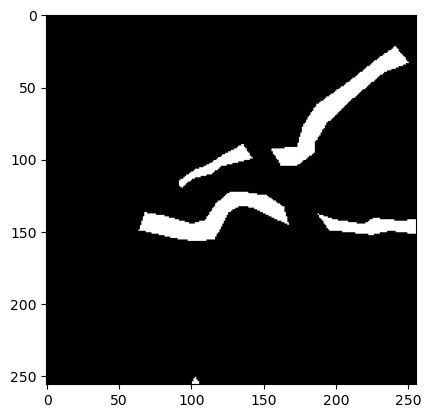

In [29]:
plt.imshow(mask_dataset[test_img_number], cmap='gray')

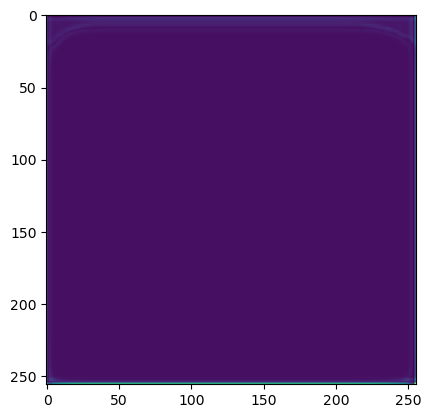

In [30]:
# # Resize the image to (256, 256)
# resized_img = cv2.resize(mask1, (256, 256))

# # Convert the image to grayscale
# # gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
# prediction[prediction < 0.5] = 0
# prediction[prediction > 0.5] = 1

prediction_image = prediction.reshape((256, 256))
plt.imshow(prediction_image)

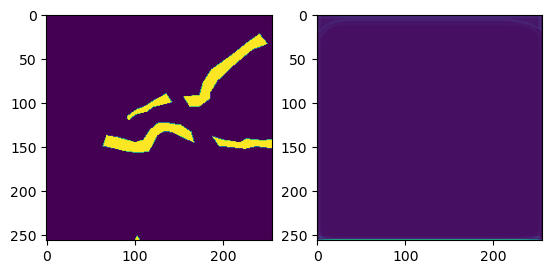

In [31]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(mask_dataset[test_img_number])
ax[1].imshow(prediction_image)
plt.show()

1/1 [==============================] - 0s 34ms/step


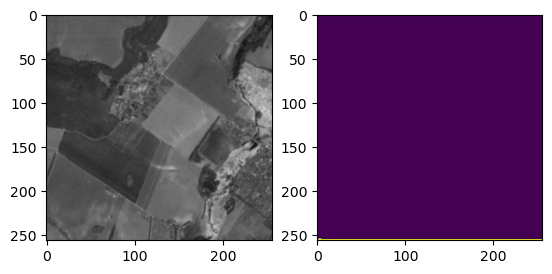

In [32]:
test_img = cv2.imread('/kaggle/input/images-soil-erosion/images/image_0_0.jp2', cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (IMG_HEIGHT, IMG_WIDTH))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)

test_img1 = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img1)[0]

#View and Save segmented image
prediction_image = prediction.reshape(256, 256)
# plt.imshow(prediction_image, cmap='gray')
# plt.imsave('membrane/test0_segmented.jpg', prediction_image, cmap='gray')

fig, ax = plt.subplots(1, 2)
ax[0].imshow(test_img)
ax[1].imshow(prediction_image)
plt.show()